# Real example
original data: jobs logs from cluster

In [1]:
import socket
import os
import sys
import bz2

if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO

#print os.path.dirname(sys.argv[0])

def printlogs(files=[],limit=3):
    print "first "+str(limit)+" of " + str(len(files)) 
    for fname in files[:limit]:
        print fname    

folder='/statistics/pico'        
if socket.gethostname().find('.')>=0:
    my_hostname=socket.gethostname()
else:
    my_hostname=socket.gethostbyaddr(socket.gethostname())[0]
if len(my_hostname.split('.')) > 1 :
    if my_hostname.split('.')[1] == 'pico' :
        folder="/cineca/usr/acct/statistics"
jobs=os.listdir(folder)
jobs.sort()
printlogs(jobs)


first 3 of 149
20150112.jobs.bz2
20150113.jobs.bz2
20150114.jobs.bz2


now we filter file jobs, decompress into string and look at the first line

In [2]:


startstring='201506'
selected_jobs = [j for j in jobs if j.endswith('.bz2') and 
              j.startswith(startstring)]
printlogs(selected_jobs)

for f in selected_jobs[:3]:
    bzf=bz2.BZ2File(os.path.join(folder,f))
    content=bzf.read()
    bzf.close()
    lines=content.split('\n')
    print lines[0]



first 3 of 9
20150601.jobs.bz2
20150602.jobs.bz2
20150603.jobs.bz2
20150601;47552;43200;20;1;129024;rcm_visual;2953;0;15;interactive;lavaldi0;0;0
20150602;47609[1];86400;1;1;4096;epigen;86486;1;15;EPIGE_prod;a07epg01;0;0
20150603;48574;21600;20;1;122880;parallel;21647;56147;15;IscrC_RASIB;mfratell;0;0


Now merge all lines into the same dataframe, with predefined fields

In [3]:
import pandas as pd

fields=['date',
        'jobid',
        'wcl',
        'cpu',
        'aff',
        'mem',
        'queue',
        'elapsed',
        'waited',
        'status',
        'account',
        'username',
        'dummy1',
        'dummy2']

Cluster=pd.DataFrame()
for f in selected_jobs:
    bzf=bz2.BZ2File(os.path.join(folder,f))
    content=bzf.read()
    bzf.close()
    DATA=StringIO(content)
    #print DATA
    df_day=pd.read_csv(
        DATA,
        sep=';',
        header=None,
        names=fields,
        parse_dates=['date']
    )
    Cluster=pd.concat([Cluster,df_day])
print "number of records: "+str(len(Cluster))
#Cluster.info()
#Cluster.head()
#Cluster.tail()

number of records: 5605


Compute another new column representing core hours

In [4]:
pd.set_option('max_rows', 5)
Cluster['core_hours'] = Cluster['cpu'] * Cluster['elapsed'] / 3600
Cluster.sort_index(by='jobid')
Cluster

#Cluster.tail()

date     jobid    wcl  cpu  aff     mem        queue  elapsed  \
0   2015-06-01     47552  43200   20    1  129024   rcm_visual     2953   
1   2015-06-01  47579[1]  82800    4    1   23552       epigen     3505   
..         ...       ...    ...  ...  ...     ...          ...      ...   
565 2015-06-09  52548[1]  43200    3    1   16384  epigen_dbio        1   
566 2015-06-09  52548[2]  43200    3    1   16384  epigen_dbio     1170   

     waited  status      account  username  dummy1  dummy2  core_hours  
0         0      15  interactive  lavaldi0       0       0   16.405556  
1         0       0   EPIGE_prod  a07epg01       0       0    3.894444  
..      ...     ...          ...       ...     ...     ...         ...  
565       1       0   EPIGE_prod  a07epg01       0       0    0.000833  
566       1       0   EPIGE_prod  a07epg01       0       0    0.975000  

[5605 rows x 15 columns]

In [5]:
for f in Cluster.columns.values.tolist(): 
    s= "field "+f+" type "+ str(Cluster[f].dtype)
    if str(Cluster[f].dtype) == 'object' :
        v=Cluster[f].value_counts()
        print s+"  "+str(len(v))+" "+\
          str(v.min())+" "+\
          str(v.mean())+" "+\
          str(v.max())+" "


field jobid type object  5605 1 1.0 1 
field queue type object  27 4 207.592592593 3994 
field account type object  20 1 280.25 1690 
field username type object  54 1 103.796296296 1687 


In [6]:
d=dict()
d['num_jobs']=[10,11]
d['tot_core_hours']=[1000,22]
mydf=pd.DataFrame.from_dict(d)
mydf

a=dict()
count=0
for f in mydf.columns :
    a[f]=count
    count = count + 1
a


{'num_jobs': 0, 'tot_core_hours': 1}

In [7]:
#group_fields=['queue','account','username']
group_fields=['queue']
stats=dict()
for f in group_fields :
    g=Cluster.groupby(f)
    stats[f]=pd.concat(
        [g['jobid'].count(),g['core_hours'].sum(), g['elapsed'].mean(), g['waited'].mean(), g['cpu'].mean(), g['mem'].mean()],
        names=['num_jobs','tot_core_hours','mean_elapsed','mean_waited','mean_cpu','mean_mem'],
        axis=1)
    stats[f]=stats[f].sort_index(by='core_hours',ascending=False)
#stats['queue'].tail()
#print stats['queue'][-3:]
for queue in stats['queue'][:6].index :
    print queue


parallel
rcm_visual
epigen
meteo
meteoser
R47051


In [8]:
def get_stats(Data,class_field,sort_field,ascending=False) :
    g=Cluster.groupby(class_field)
    stats=pd.concat(
        [g['jobid'].count(),g['core_hours'].sum(), g['elapsed'].mean(), g['waited'].mean(), g['cpu'].mean(), g['mem'].mean()],
        axis=1)
    stats=stats.sort_index(by=sort_field,ascending=ascending)
    return stats
for queue in get_stats(Cluster,'queue','core_hours')[:6].index :
    print queue

parallel
rcm_visual
epigen
meteo
meteoser
R47051


Setup Bokeh plotting libraries


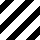
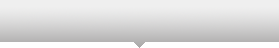
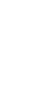
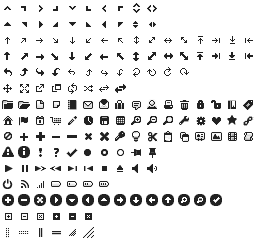
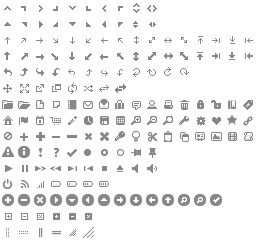
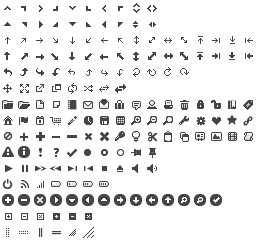
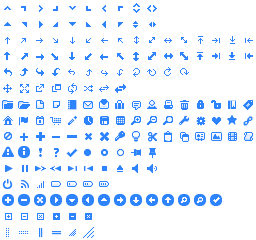
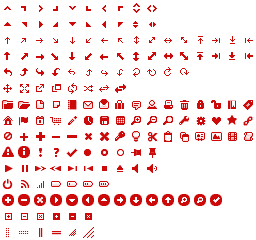
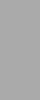
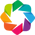
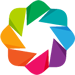
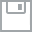
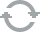
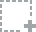
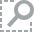
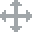
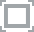
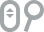


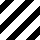
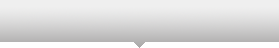
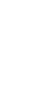
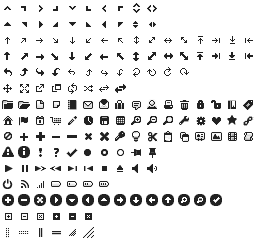
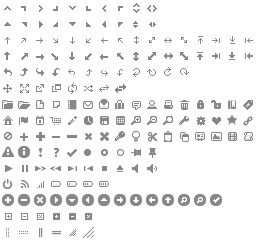
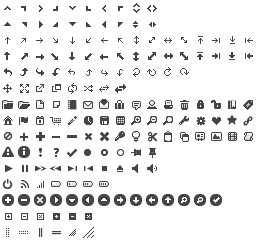
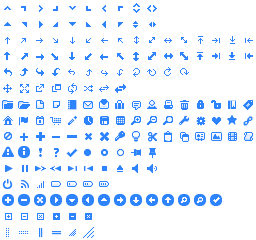
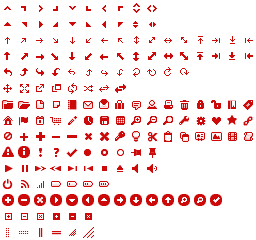
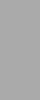
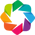
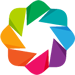
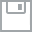
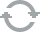
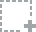
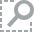
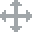
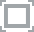
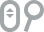

In [9]:
import numpy
import bokeh
import bokeh.charts
import bokeh.plotting
from bokeh.models import HoverTool 
bokeh.charts.output_notebook()
bokeh.plotting.output_notebook()


function for  an individual jobs scatter plot

In [11]:
def individual_jobs_scatter_plot(Data,stats,class_field,x_field,y_field,size_field,desc_field ,width=500,height=500,sort_field='') :

    if not sort_field : sort_field=size_field
    count=0
    field_index=dict()
    for f in Data.columns :
        field_index[f]=count
        count = count + 1
    colors=['#ff0000','#00ff00','#0000ff','#ff00ff','#00ffff','#ffff00']
    tools="reset,hover,pan,wheel_zoom,resize,box_zoom"
    plot_fields=[x_field,y_field,size_field,desc_field]
    s=dict()
    ctot=0
    fig = bokeh.plotting.figure(tools=tools,
                            x_axis_label=x_field,
                            y_axis_label=y_field)
    stats=get_stats(Data,class_field,sort_field)
    for i in stats[:len(colors)].index :
        a=Data[(Data[class_field] == i)][plot_fields].values
        x=a[:,0]
        y=a[:,1]
        size=a[:,2]/100
        source = bokeh.plotting.ColumnDataSource(
          data=dict(
            val=a[:,2],
            desc=a[:,3],
          )
        )
        if ctot < len(colors) :
            color = colors[ctot]
        else:
            color='#000000'
        ctot = ctot +1

        s= fig.scatter(width=width,height=height,
                    x=x,
                    y=y,
                    color=color,
                    size=size,
                    source=source,
                    legend=i+ ' '+str(len(a)))
        s.select(dict(type=HoverTool)).tooltips = {plot_fields[3]:"@desc",plot_fields[2]:"@val"}
    return fig
                
fig= individual_jobs_scatter_plot(Cluster,stats,'queue','cpu','elapsed','core_hours','account' )
bokeh.charts.show(fig)

In [18]:
fig0= individual_jobs_scatter_plot(Cluster,stats,'queue','cpu','elapsed','core_hours','account',width=400,height=500 )
fig1= individual_jobs_scatter_plot(Cluster,stats,'queue','elapsed','waited','core_hours','account',width=400,height=500 )
fig2= individual_jobs_scatter_plot(Cluster,stats,'queue','mem','waited','core_hours','account',width=400,height=500 )
fig3= individual_jobs_scatter_plot(Cluster,stats,'account','cpu','mem','core_hours','queue',width=400,height=500 )
fig4= individual_jobs_scatter_plot(Cluster,stats,'account','core_hours','waited','elapsed','queue',width=400,height=500 )
p=bokeh.io.hplot(fig0,fig1,fig2,fig3,fig4)
bokeh.charts.show(p)

In [16]:
#fig = bokeh.plotting.figure(tools=[hover])
#fig.background_fill = "black"
colors=['#ff0000','#00ff00','#0000ff','#ff00ff','#00ffff','#ffff00']
plot_fields=['cpu','elapsed','core_hours','account']
tools="reset,hover,pan,wheel_zoom,resize,box_zoom"


s=dict()
ctot=0
fig = bokeh.plotting.figure(tools="reset,hover,pan,wheel_zoom,resize,box_zoom",
                            x_axis_label=plot_fields[0],
                            y_axis_label=plot_fields[1])

for i in stats['queue'][:len(colors)].index :
#    print "queue-->"+i
#    p = sel[(Cluster.queue == i)][['elapsed','waited']]
#    p = sel[(Cluster.queue == i)][['elapsed','waited']]
#    a=.values
    a=Cluster[(Cluster.queue == i)][plot_fields].values
    x=a[:,0]
    y=a[:,1]
    size=a[:,2]/100
    source = bokeh.plotting.ColumnDataSource(
      data=dict(
#        x=x,
#        y=y,
        val=a[:,2],
        desc=a[:,3],
      )
    )
#    fig.circle('x', 'y', size=20, source=source)
    if ctot < len(colors) :
        color = colors[ctot]
    else:
        color='#000000'
    ctot = ctot +1

    s[i] = fig.scatter(x=x,
                    y=y,
                    color=color,
                    size=size,
                    source=source,
                    legend=i+ ' '+str(len(a)))
    s[i].select(dict(type=HoverTool)).tooltips = {plot_fields[3]:"@desc",plot_fields[2]:"@val"}
    
bokeh.charts.show(fig)

In [168]:
relevant=dict()
for f in fields: 
    v=Cluster[f].value_counts()
    print "different_values of "+\
          f+"  "+str(len(v))+" "+\
          str(v.mean())+" "+\
          str(v.min())+" "+\
          str(v.max())+" "
    #relevant[f]=v[()]
v=Cluster['queue'].value_counts()
v.sort()
relev=[]
for k in v.keys():
    if v[k] > 0.1*v.mean() : relev.append(k)
print relev
#relevant=dict()
#for f in ['queue','account']: 
#    g=Cluster.groupby('queue')
#used_queue=[]
#for q in g.group


different_values of date  9 622.777777778 55 1348 
different_values of jobid  5605 1.0 1 1 
different_values of wcl  32 175.15625 1 2205 
different_values of cpu  33 169.848484848 1 1785 
different_values of aff  1 5605.0 5605 5605 
different_values of mem  55 101.909090909 1 1665 
different_values of queue  27 207.592592593 4 3994 
different_values of elapsed  2098 2.67159199237 1 262 
different_values of waited  1703 3.291250734 1 1842 
different_values of status  3 1868.33333333 16 5367 
different_values of account  20 280.25 1 1690 
different_values of username  54 103.796296296 1 1687 
different_values of dummy1  1 5605.0 5605 5605 
different_values of dummy2  1 5605.0 5605 5605 
['meteo', 'serial', 'rcm_visual', 'epigen_dbio', 'meteoser', 'epigen', 'parallel']



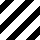
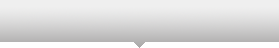
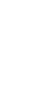
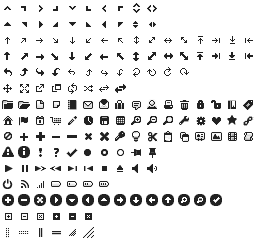
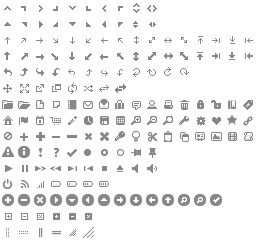
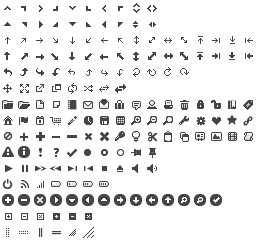
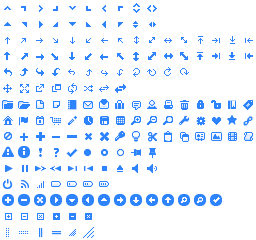
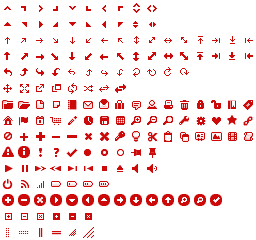
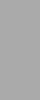
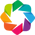
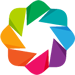
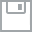
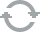
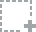
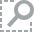
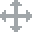
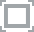
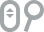


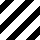
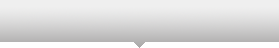
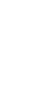
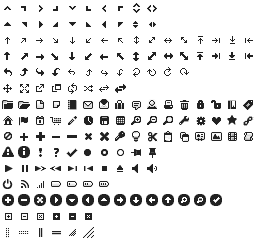
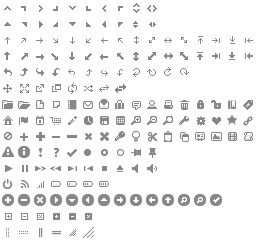
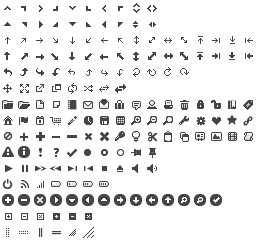
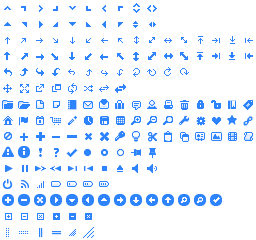
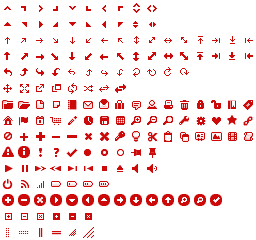
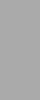
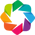
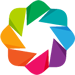
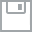
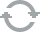
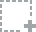
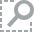
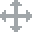
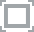
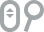

In [217]:
import numpy as np
#import bokeh.plotting as bp
import bokeh
import bokeh.charts
import bokeh.plotting
from bokeh.models import HoverTool 
bokeh.charts.output_notebook()
bokeh.plotting.output_notebook()
#bp.output_file('test.html')
#import matplotlib.pyplot as plt

import numpy
import random
from collections import OrderedDict
import pandas as pd

# skip site cert check
#http://stackoverflow.com/questions/27835619/ssl-certificate-verify-failed-error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
#ssl.create_default_context(capath=False)
'''
Cluster = pd.read_csv(
    "https://hpc-forge.cineca.it/files/Visualization_School/public/20150315.jobs",
    sep=';',
    header=None,
    names=['date',
           'jobid',
           'wcl',
           'cpu',
           'aff',
           'mem',
           'queue',
           'elapsed',
           'waited',
           'status',
           'account',
           'username','unknown'],
    parse_dates=['date'])
'''
sel = Cluster[['elapsed','waited', "queue"]]
#print sel
grouped_df=sel.groupby("queue")
pdict = OrderedDict()




In [170]:
fig1 = bokeh.plotting.figure(tools="reset,hover,pan,wheel_zoom")
x1 = np.linspace(0,2*np.pi)
x2 = np.linspace(0,2.3*np.pi)
y1 = np.sin(x1)
y2 = np.cos(x2)
s1 = fig1.scatter(x=x1,y=y1,color='#0000ff',size=10,legend='sine')
#s1.select(dict(type=HoverTool)).tooltips = {"x":"$x", "y":"$y"}
s2 = fig1.scatter(x=x2,y=y2,color='#ff0000',size=10,legend='cosine')
#s2.select(dict(type=HoverTool)).tooltips = OrderedDict([("x","@x"),("y","@y")])
s3 = fig1.scatter(x=x2,y=y1,color='#00ffff',size=10,legend='sineooo')
#s3.select(dict(type=HoverTool)).tooltips = {"xx":"$x", "y":"$y"}
s4 = fig1.scatter(x=x1,y=y2,color='#ffff00',size=10,legend='cccosine')
s4.select(dict(type=HoverTool)).tooltips = OrderedDict([("ddx","@x"),("y","@y")])
bokeh.charts.show(fig1)

In [223]:
fig = bokeh.plotting.figure(tools="reset,hover,pan,wheel_zoom")
#fig.background_fill = "black"
s=dict()
ctot=0
colors=dict()
colors[0]='#ff0000'
colors[1]='#00ff00'
colors[2]='#0000ff'
colors[3]='#ff00ff'
colors[4]='#00ffff'
colors[5]='#ffff00'
for i in grouped_df.groups.keys():
    print i,type(i)
#  if  i =='debug' or i == 'smallpar':
#  if  i =='debug' :
#  if  i =='debug' or i == 'longdebug':
#  if  i =='debug' or i == 'serial':
#  if  i =='parallel' or i == 'smallpar':
#  if  i =='serial' or i == 'bigpar' or i == 'longdebug':
#  if  i =='serial' or i == 'smallpar' or i == 'longdebug':
#  if  i =='debug' or i == 'smallpar' or i == 'longdebug':
#  if  i =='debug' or i == 'smallpar' or i == 'bigpar':
#  if  i =='serial' or i == 'smallpar' or i == 'bigpar':
    ctot = ctot +1
    p = sel[(sel.queue == i)][['elapsed','waited']]
    a=p.values
#    x=p[['elapsed']].values
#    y=p[['waited']].values
    x=a[:,0]
    y=a[:,1]
    #print len(a)
    #print x
    #c=plt.cm.RdYlBu((ctot*100)%256)
    #cc=(int(c[0]*256),int(c[1]*256),int(c[2]*256),c[3])
    s[i] = fig.scatter(x=x,
                    y=y,
                    color=colors.get(ctot,'#000000'),
                    size=5,
                    legend=i+ ' '+str(len(a)))
    s[i].select(dict(type=HoverTool)).tooltips = {"x":"@x", "y":"$y"}
    
bokeh.charts.show(fig)

R48654 <type 'str'>
R48653 <type 'str'>
R49627 <type 'str'>
R49626 <type 'str'>
meteoser <type 'str'>
meteo <type 'str'>
rcm_visual <type 'str'>
serial <type 'str'>
R50323 <type 'str'>
R50324 <type 'str'>
system <type 'str'>
R50956 <type 'str'>
R50955 <type 'str'>
R51463 <type 'str'>
epigen <type 'str'>
epigen_dbio <type 'str'>
parallel <type 'str'>
bigmem <type 'str'>
R47052 <type 'str'>
R47051 <type 'str'>
R47618 <type 'str'>
R47617 <type 'str'>
R46930 <type 'str'>
R46931 <type 'str'>
R46140 <type 'str'>
R46615 <type 'str'>
R46614 <type 'str'>
